## W266-Final-Project
### Neural Narratives for Multiple Images
#### Team: Sundeep Kumar Mahensaria, Eric Lee

### Exploratory Data Analysis

In [1]:
import json
import pandas as pd
import os

In [2]:
os.getcwd()

'C:\\Users\\sundeepm\\source\\MIDS\\w266\\w266-final-project'

In [4]:
with open (".\\VIST\\sis\\val.story-in-sequence.json") as f:
    data = json.load(f)

In [5]:
# Build the image dictionary, which is querable by image id.

image_by_id = {x["id"]: x for x in data["images"]}
print(f"Number of images: {len(image_by_id.keys())}")
list(image_by_id.keys())[:5]


Number of images: 21048


['694227468', '694227344', '694227412', '694227488', '694227508']

In [6]:
# Builds the story dictionary, which is querable by story id.

df = pd.DataFrame([d[0] for d in data["annotations"]])
stories = df.groupby(["story_id"])
story_by_id = {k: stories.get_group(k).to_dict(orient='records') for k in stories.groups.keys()}
print(f"Number of stories: {len(story_by_id.keys())}")
list(story_by_id.keys())[:5]


Number of stories: 4990


['40470', '40471', '40472', '40473', '40474']

In [7]:
from PIL import Image
import requests
from io import BytesIO

def explore_images(story_id):
    story_photos = [{"text": x["text"], "image": image_by_id[x["photo_flickr_id"]]["url_o"]} for x in story_by_id[story_id]]
    
    for photo in story_photos:
        response = requests.get(photo["image"])
        img = Image.open(BytesIO(response.content))
        print(photo["text"])
        display(img)


we gathered up some fire works to set off at dark .


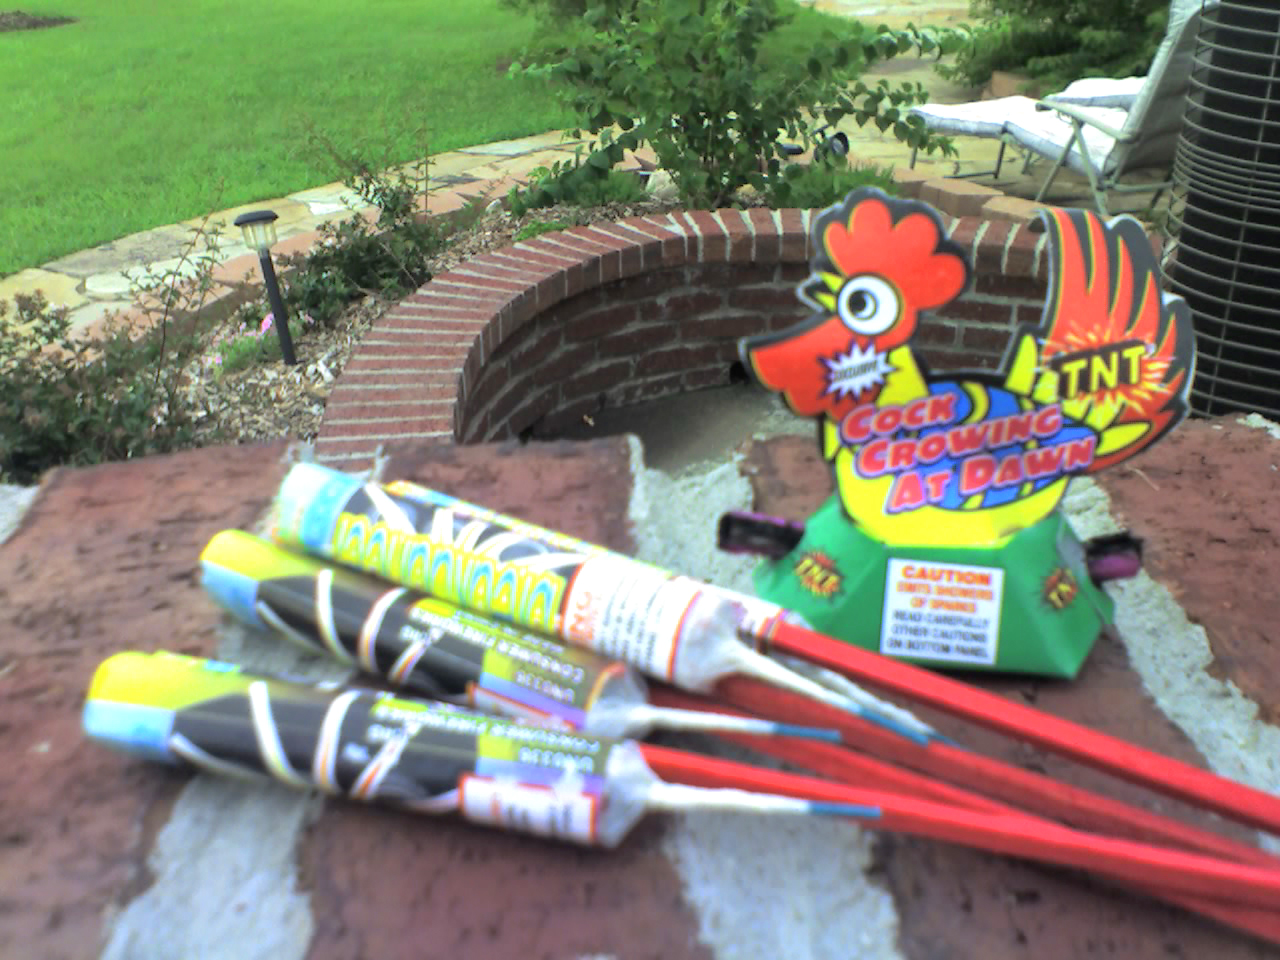

we grilled some burgers that were oddly shaped .


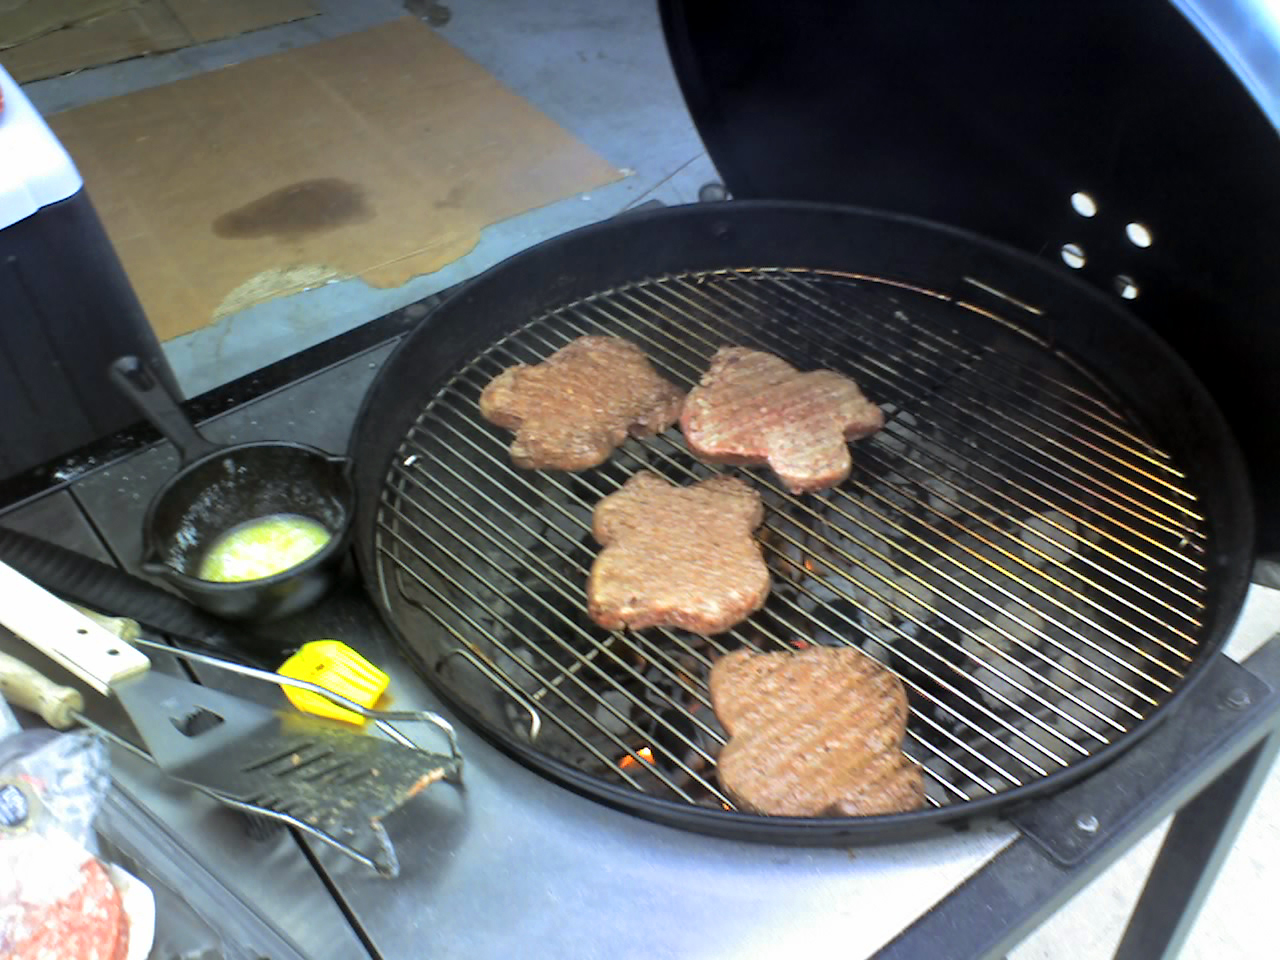

our friends trickled in one by one !


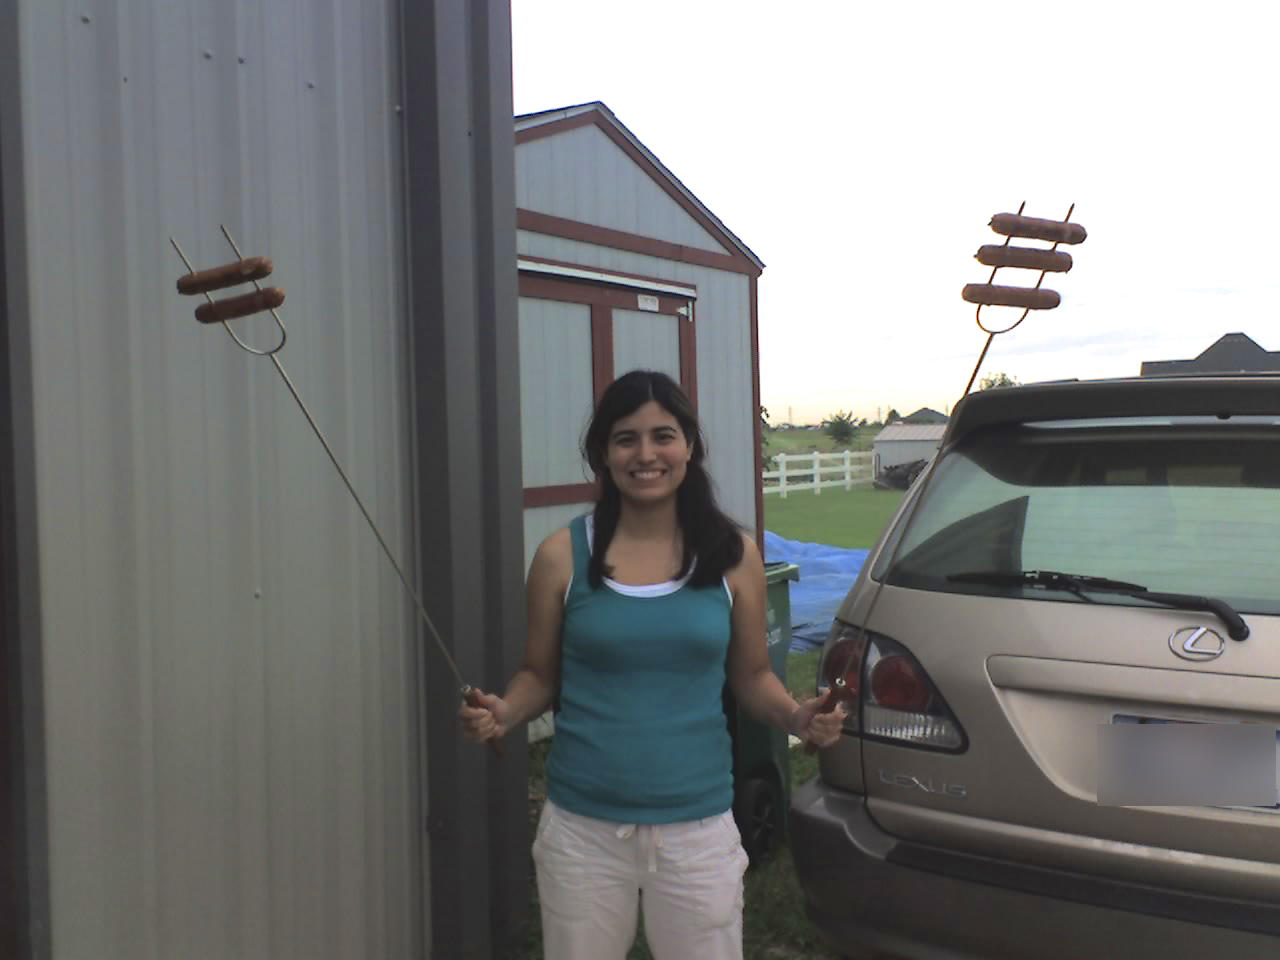

we got all the food on the grill to cook and ready to eat .


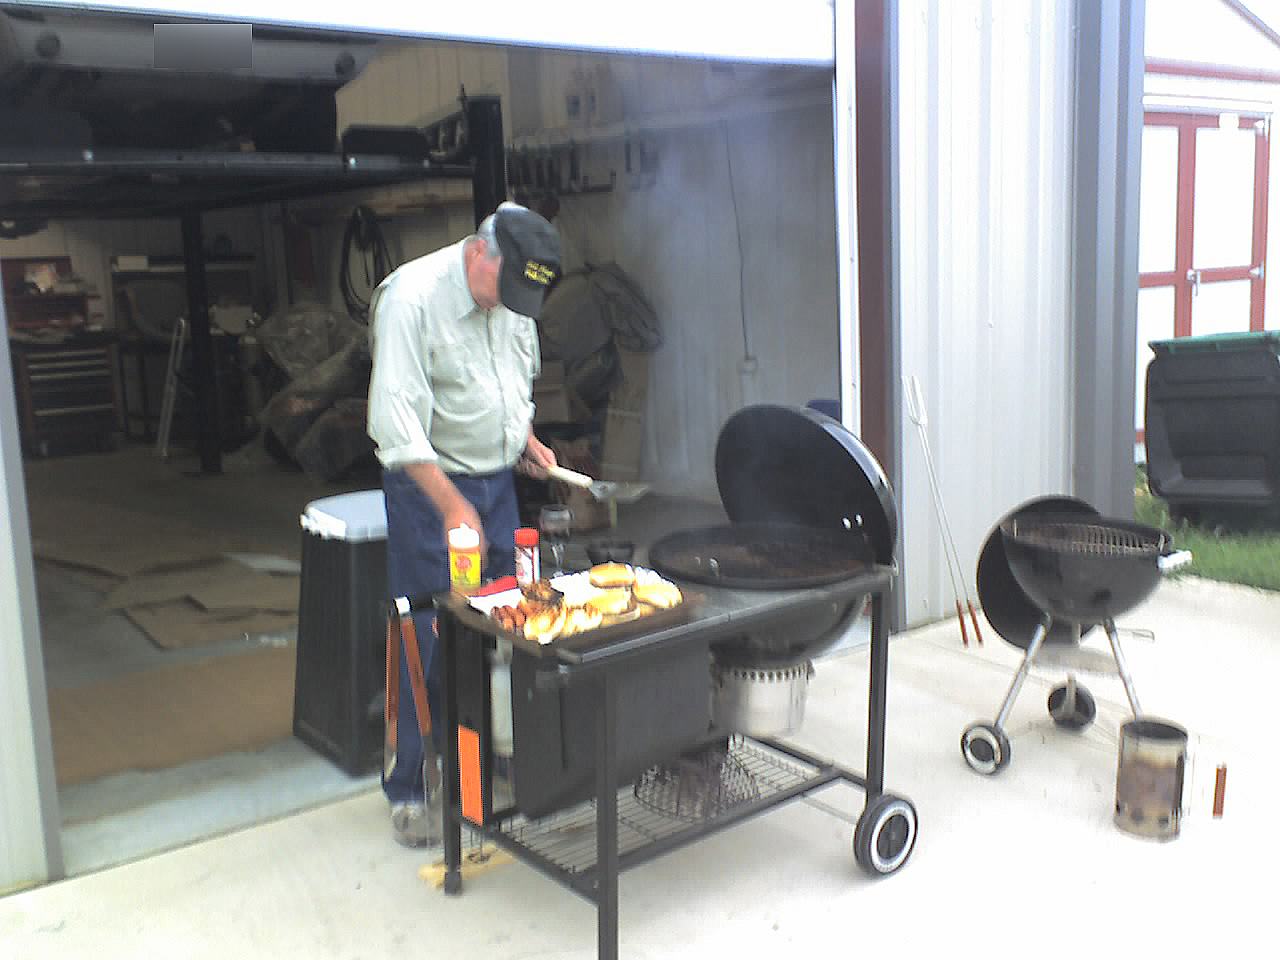

the sunset was amazing that night !


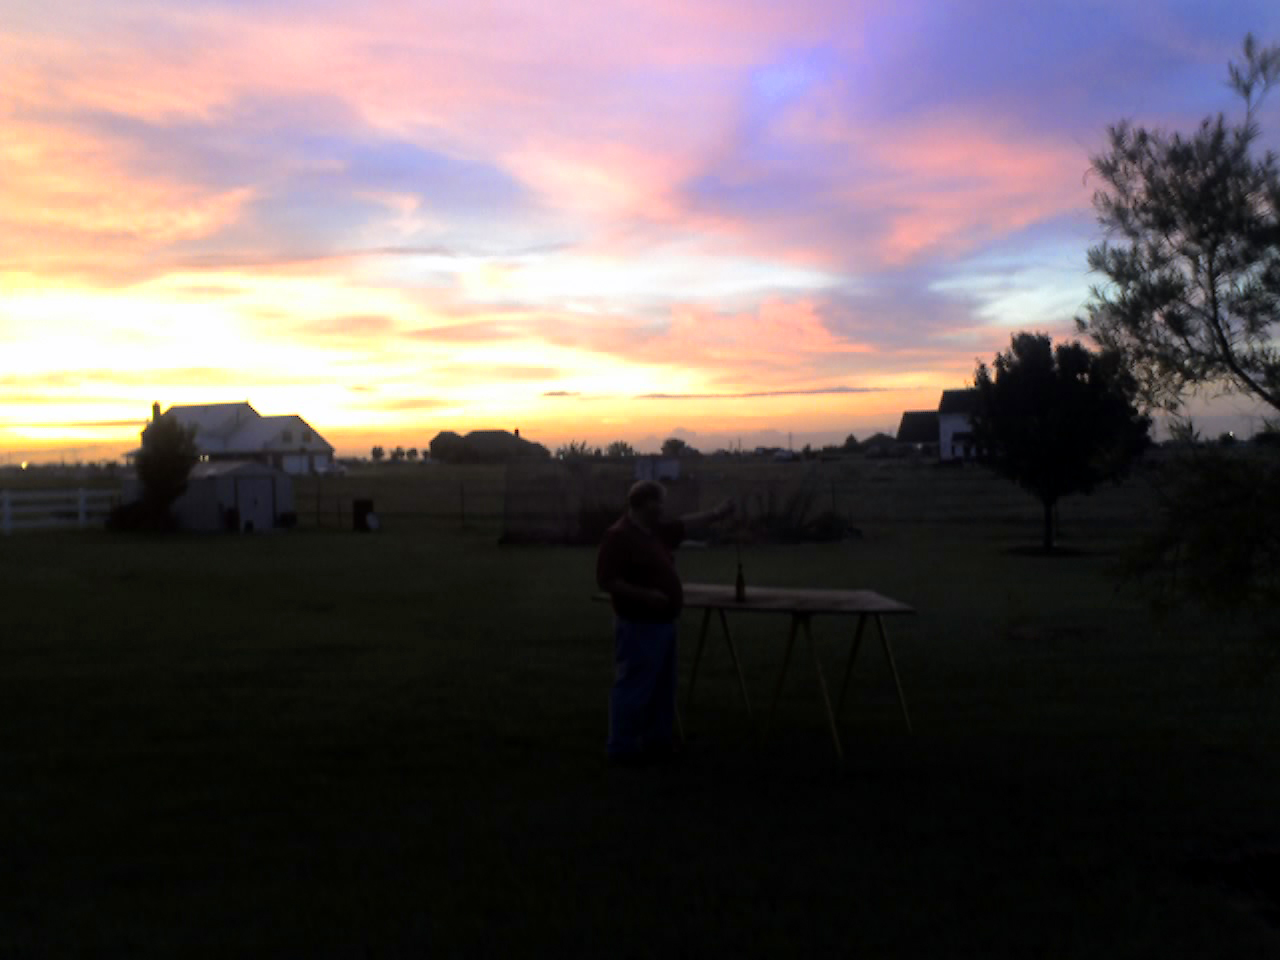

In [8]:
explore_images("40471")

### Write annotations to file for fine tuning GPT-2 model

In [9]:
# Opening JSON file
#f_dii_train = open('.\\VIST\\dii\\train.description-in-isolation.json',)
f_dii_val = open('.\\VIST\\dii\\val.description-in-isolation.json',)
#f_dii_test = open('.\\VIST\\dii\\test.description-in-isolation.json',)

f_sis_train = open('.\\VIST\\sis\\train.story-in-sequence.json',)
f_sis_val = open('.\\VIST\\sis\\val.story-in-sequence.json',)
f_sis_test = open('.\\VIST\\sis\\test.story-in-sequence.json',)


# returns JSON object as
# a dictionary
#data_dii_train = json.load(f_dii_train)
data_dii_val = json.load(f_dii_val)
#data_dii_test = json.load(f_dii_test)

data_sis_train = json.load(f_sis_train)
data_sis_val = json.load(f_sis_val)
data_sis_test = json.load(f_sis_test)

# Iterating through the json
# list
#for i in data_dii['images']:
#    print(i)

# Closing file
#f_dii_train.close()
f_dii_val.close()
#f_dii_test.close()

#f_sis_train.close()
f_sis_val.close()
#f_sis_test.close()


In [10]:
sis_file = open("VIST_sis_train.txt", "w")

count = 0
for s in data_sis_train['annotations']:
    count += 1
    sis_file.write(s[0]['text'])
    
sis_file.close()
print("#Records:", count)

#Records: 200775


## Use Vanilla GPT2 [https://huggingface.co/gpt2]

In [11]:
from transformers import pipeline, set_seed
generator = pipeline('text-generation', model='gpt2')
set_seed(42)


In [12]:
#Understanding GPT-2 model architecture
from transformers import GPT2Tokenizer, TFGPT2Model

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = TFGPT2Model.from_pretrained('gpt2')
text = "Replace me by any text you'd like."
encoded_input = tokenizer(text, return_tensors='tf')

output = model(encoded_input)


All model checkpoint layers were used when initializing TFGPT2Model.

All the layers of TFGPT2Model were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


In [13]:
model.summary()

Model: "tfgp_t2model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
transformer (TFGPT2MainLayer multiple                  124439808 
Total params: 124,439,808
Trainable params: 124,439,808
Non-trainable params: 0
_________________________________________________________________


In [14]:
(output)

TFBaseModelOutputWithPast(last_hidden_state=<tf.Tensor: shape=(1, 10, 768), dtype=float32, numpy=
array([[[ 0.16212572, -0.21588519, -0.14169699, ..., -0.26142448,
         -0.08208865,  0.0090347 ],
        [ 0.4627184 ,  0.02478069, -0.07850035, ..., -0.0860274 ,
          0.5116983 , -0.39420223],
        [-0.06408694,  0.15478237, -0.63063264, ...,  0.24884976,
          0.36889797,  0.08327581],
        ...,
        [-0.55880547, -0.44919202, -1.4540863 , ...,  0.1651334 ,
         -0.1303169 , -0.37356   ],
        [ 0.13995859, -0.38752723, -0.79088736, ..., -0.17763196,
          0.18202348,  0.21815243],
        [ 0.17187801, -0.24292184, -0.1124271 , ..., -0.10721985,
          0.12059784, -0.3214077 ]]], dtype=float32)>, past_key_values=(<tf.Tensor: shape=(2, 1, 12, 10, 64), dtype=float32, numpy=
array([[[[[-1.07186723e+00,  2.41698933e+00,  9.66034472e-01, ...,
           -4.78705883e-01, -3.31557035e-01,  1.79252338e+00],
          [-2.28969455e+00,  2.54237127e+00,  8.317

In [15]:
type(output)

transformers.modeling_tf_outputs.TFBaseModelOutputWithPast

## Fine-tuned GPT-2 (using SIS val train dataset)
### Compare scores for combined naratives (complete story) vs 5 individual image story langauges

#### Load libraries

In [16]:
#GPT-2
from transformers import pipeline, set_seed
generator = pipeline('text-generation', model='gpt2')
set_seed(42)

#BLEU
from nltk.translate.bleu_score import sentence_bleu

#ROUGE
from rouge_score import rouge_scorer
Rouge_scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

#BERT SCORE
from bert_score import BERTScorer
scorer = BERTScorer(lang="en", rescale_with_baseline=True)

#METEOR
import nltk

#### Check scores of combined narratives (complete story)

In [7]:
#Complete Story

references = []
references.append("Six or seven bottle rockets next to a specialty firework.the burgers are being grilled on the grill.A woman has big forks with meat on them. An older man stands in the entry of a garage, manning his station at the grill. A man is standing in front of some saw horses at dusk.[male] [male] was excited to go to the carnival .he started off with a ride on a couple of rides .afterwards he took a picture of a truck .he was really excited to go .he was so excited to see all the animals .he had a great time .there were so many rides and games at the carnival , i had to take a picture .i was excited to see all the animals .the food was really good , i got to ride in one .we took a picture with the trucks on the way home .the park is a great place to go .the kids need to have fun .the carnival is great for everyone .the kids all love to play .the food is really good .the carnival is a great place to enjoy the night .the kids are having a great time at the carnival .the children are having fun at the carnival .the kids are having fun with their friends .the kids are having fun at the rodeo .the kids are having fun at the rodeo .a group of friends gets together for a party .a man gets in a car and drives away .a woman is seen walking around with a man in a blue dress .a man is")

references.append("Six or seven bottle rockets next to a specialty firework.the burgers are being grilled on the grill.A woman has big forks with meat on them. An older man stands in the entry of a garage, manning his station at the grill. A man is standing in front of some saw horses at dusk.a man is eating a burger at a restaurant .a man is in a garage at the garage .a sign is posted outside of the garage .it was a night out on the town .they were always having fun .they drove the hot 4x4 in the dirt .they played in the mud .as they drove off to the next destination , they were glad they had done it .the family was getting ready to go out for a night out .they drove through a long dirt road .it was very bumpy , but they had fun .the day was a good start to a good vacation .the weather was nice , but they had to stop for a moment .they enjoyed a good dinner .the family got together to take pictures .they got some snacks before heading out .the family got ready to go out for the night .the kids had fun playing in the mud .a couple of men were talking .the couple took the kids to the beach .they had fun at the beach .we went to a fireworks show .we had a great time .there were a lot of participants .some people had huge buckets .we had a great time watching them .we had a great time at the fireworks show .the people started in late afternoon")

references.append("Six or seven bottle rockets next to a specialty firework.the burgers are being grilled on the grill.A woman has big forks with meat on them. An older man stands in the entry of a garage, manning his station at the grill. A man is standing in front of some saw horses at dusk.a young couple is sitting in the garage waiting for the burgers to be done .the couple are finished eating and ready to go .the burgers are to be served .the husband and wife were having their first dinner .they were starting the burgers .they had a great time .everyone had a great time .they had a great time .the wedding was very peaceful .the family was looking forward to the reception .the girls had along with her brother .the priest was very happy for them .the bride and groom got along very well .the couple enjoyed a good meal together .the wedding was beautiful .the groom looked amazing .the bride looked so happy to be with her family .the wedding party was ready for the wedding .even the bride 's brother was in attendance .they were very happy to be there .they were so happy that they were able to celebrate with each other .the wedding reception had fun and lots of laughter .the guests were happy to be there .the bride and groom looked great together .they were so happy together .the bridesmaid looked beautiful .the guests were happy to see each other .the bride and groom had a great time .the bride and groom were happy to be together .we had a wonderful wedding .")

references.append("Six or seven bottle rockets next to a specialty firework.the burgers are being grilled on the grill.A woman has big forks with meat on them. An older man stands in the entry of a garage, manning his station at the grill. A man is standing in front of some saw horses at dusk.a firework is seen in the background .the neighborhood had an indoor firework show .they highlighted the area with a giant yellow firework .they waited until dusk to light the firework .the firework was spectacular .once it started , it was spectacular .the sky was lit up , the firework lit up the night sky .the sky was full of light and colorful light .the bright firework lit up the night sky .once it was dark , it was time to light more .sadly , the night sky was lit up again .the family was in the city for a christmas party .the family was standing outside during the christmas party .the family was ready to light the christmas tree .the family was very excited to be outside of the building .the entire family had such a great time .they set the christmas tree on the table .the family then drove out to the city .there was a christmas party at the house .the family was still going to the party because it was so hot .they had such a nice christmas tree there .everyone got in the car to get a nice christmas treat .everyone arrived in the car and headed to see the decorations .there was a christmas")

references.append("Six or seven bottle rockets next to a specialty firework.the burgers are being grilled on the grill.A woman has big forks with meat on them. An older man stands in the entry of a garage, manning his station at the grill. A man is standing in front of some saw horses at dusk.it 's time for a picture to remember this one .this one was the first one i saw of the rocket .the other ones were really big .i wonder if this one will just be eaten with a spoon .the man looks tired but smiling on the side of the truck .the man stands in front of the car with his big chain .the man is ready to go in the rocket .the wings are all set for the big rocket .the rocket is waiting for the crew to arrive .the rocket is ready and about to go .the man is ready to go in the rocket .we went on a trip to the location location location location .there were a lot of unique things to see .we saw different types of buildings and we saw some interesting looking vehicles .we saw many different kinds of cars .we also took several pictures of the city .the trip was a success , the city was very vibrant .we enjoyed the city , many interesting buildings .the city had a ton of different uses .we took many photos in the city .we saw many different vehicles .the city was very vibrant and was very long .we had a great time and were able to see a lot in the city .the city was surrounded by fences and other")

hypothesis = ["we gathered up some fire works to set off at dark . we grilled some burgers that were oddly shaped . our friends trickled in one by one ! we got all the food on the grill to cook and ready to eat . the sunset was amazing that night !"]

In [188]:
for r in references:
    print([r])
    print("-------------------------------------------")
    P, R, F1 = scorer.score(hypothesis, [r])
    print('Bert Score - P:', P, 'R:', R, 'F1:', F1)
    print("METEOR:", nltk.translate.meteor_score.meteor_score(hypothesis[0], r, 4))
    print("ROUGE:", Rouge_scorer.score(hypothesis[0], r))
    print('BLEU: {}'.format(sentence_bleu(hypothesis[0], r, weights=(1, 0, 0, 0))))
    print("===========================================")

['Six or seven bottle rockets next to a specialty firework.the burgers are being grilled on the grill.A woman has big forks with meat on them. An older man stands in the entry of a garage, manning his station at the grill. A man is standing in front of some saw horses at dusk.[male] [male] was excited to go to the carnival .he started off with a ride on a couple of rides .afterwards he took a picture of a truck .he was really excited to go .he was so excited to see all the animals .he had a great time .there were so many rides and games at the carnival , i had to take a picture .i was excited to see all the animals .the food was really good , i got to ride in one .we took a picture with the trucks on the way home .the park is a great place to go .the kids need to have fun .the carnival is great for everyone .the kids all love to play .the food is really good .the carnival is a great place to enjoy the night .the kids are having a great time at the carnival .the children are having fun 

Bert Score - P: tensor([0.1073]) R: tensor([-0.1466]) F1: tensor([-0.0213])
METEOR: 0.01742160278745645
ROUGE: {'rouge1': Score(precision=0.0931899641577061, recall=0.5652173913043478, fmeasure=0.16), 'rougeL': Score(precision=0.053763440860215055, recall=0.32608695652173914, fmeasure=0.0923076923076923)}
BLEU: 0.016558675305975518


#### Image Caption 1 with text length = 250

In [189]:
#Image Caption 1

hypothesis = []
hypothesis.append("Six or seven bottle rockets next to a specialty firework.[male] and [female] are having a great time and are having fun .the fireworks started just before sunset .the yellow blast did n't stop the sun from setting .on the other side of the fireworks the red blast did .the fireworks")

hypothesis.append("Six or seven bottle rockets next to a specialty firework. ''the old-fashioned rocket in the sky was a great rocket for the kids .the old rocket in the sky was the star that laid the foundation for the school .the little ones had to take off the rocket and ride it .the little ones")

hypothesis.append("Six or seven bottle rockets next to a specialty firework.i love new rockets .they look like the sparklers on a christmas tree .the ones from the holidays are amazing .the red ones are awesome too .the ones from the past have been so much better .the big red ones are my favorite")

hypothesis.append("Six or seven bottle rockets next to a specialty firework. [male] ?the next rocket was a cool one . it was a rocket that exploded in the sky .the next one was a little more complex . it had a red firework on top .it was a great day for fireworks .they had")

hypothesis.append("Six or seven bottle rockets next to a specialty firework.i love this car .my family and i bought it from a bbq truck .the engine was from a different company .the new car was tucked away in the trunk .the new car was beautiful .the company is taking a picture of the")

reference = ["we gathered up some fire works to set off at dark ."]

In [190]:
for h in hypothesis:
    print([h])
    print("-------------------------------------------")
    P, R, F1 = scorer.score(reference, [h])
    print('Bert Score - P:', P, 'R:', R, 'F1:', F1)
    print("METEOR:", nltk.translate.meteor_score.meteor_score(reference[0], h, 4))
    print("ROUGE:", Rouge_scorer.score(reference[0], h))
    print('BLEU: {}'.format(sentence_bleu(reference[0], h, weights=(1, 0, 0, 0))))
    print("===========================================")

["Six or seven bottle rockets next to a specialty firework.[male] and [female] are having a great time and are having fun .the fireworks started just before sunset .the yellow blast did n't stop the sun from setting .on the other side of the fireworks the red blast did .the fireworks"]
-------------------------------------------
Bert Score - P: tensor([0.2718]) R: tensor([-0.0491]) F1: tensor([0.1077])
METEOR: 0.08474576271186442
ROUGE: {'rouge1': Score(precision=0.038461538461538464, recall=0.18181818181818182, fmeasure=0.0634920634920635), 'rougeL': Score(precision=0.038461538461538464, recall=0.18181818181818182, fmeasure=0.0634920634920635)}
BLEU: 0.06382978723404255
["Six or seven bottle rockets next to a specialty firework. ''the old-fashioned rocket in the sky was a great rocket for the kids .the old rocket in the sky was the star that laid the foundation for the school .the little ones had to take off the rocket and ride it .the little ones"]
-----------------------------------

#### Image Caption 1 with text length = 25

In [11]:
#Image Caption 1-B

hypothesis = []
hypothesis.append("i got a lot of cool rockets for the party .they were all different")

hypothesis.append("a cool picture of the props we used to show off .the nice red")

hypothesis.append("i had a great time at the party last weekend .the food was very")

hypothesis.append("a cool ceramics set for the firework show .our first fire")

hypothesis.append("the firework was labeled `` jenga '' .i never get tired")

reference = ["we gathered up some fire works to set off at dark ."]

In [12]:
for h in hypothesis:
    print([h])
    print("-------------------------------------------")
    P, R, F1 = scorer.score(reference, [h])
    print('Bert Score - P:', P, 'R:', R, 'F1:', F1)
    print("METEOR:", nltk.translate.meteor_score.meteor_score(reference[0], h, 4))
    print("ROUGE:", Rouge_scorer.score(reference[0], h))
    print('BLEU: {}'.format(sentence_bleu(reference[0], h, weights=(1, 0, 0, 0))))
    print("===========================================")

['i got a lot of cool rockets for the party .they were all different']
-------------------------------------------
Bert Score - P: tensor([0.3178]) R: tensor([0.1910]) F1: tensor([0.2548])
METEOR: 0.2173913043478261
ROUGE: {'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0, recall=0.0, fmeasure=0.0)}


C:\Users\sundeepm\Anaconda3\envs\W203\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\sundeepm\Anaconda3\envs\W203\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\sundeepm\Anaconda3\envs\W203\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram or

BLEU: 0.24242424242424243
['a cool picture of the props we used to show off .the nice red']
-------------------------------------------
Bert Score - P: tensor([0.2249]) R: tensor([0.1217]) F1: tensor([0.1741])
METEOR: 0.2173913043478261
ROUGE: {'rouge1': Score(precision=0.21428571428571427, recall=0.2727272727272727, fmeasure=0.23999999999999996), 'rougeL': Score(precision=0.21428571428571427, recall=0.2727272727272727, fmeasure=0.23999999999999996)}
BLEU: 0.24590163934426226
['i had a great time at the party last weekend .the food was very']
-------------------------------------------
Bert Score - P: tensor([0.1456]) R: tensor([0.1131]) F1: tensor([0.1307])
METEOR: 0.2173913043478261
ROUGE: {'rouge1': Score(precision=0.07142857142857142, recall=0.09090909090909091, fmeasure=0.08), 'rougeL': Score(precision=0.07142857142857142, recall=0.09090909090909091, fmeasure=0.08)}
BLEU: 0.2698412698412698
['a cool ceramics set for the firework show .our first fire']
-----------------------------

#### Image Caption 2 with text length = 250

In [191]:
#Image Caption 2

references = []
references.append("the burgers are being grilled on the grill.this is the grill where we were asked to sit .we had to wait in line to get our food .me and my girlfriend were sitting around a restaurant going over the menu .we had a great time and got to chat with some of the staff")

references.append("the burgers are being grilled on the grill.we are going to be eating some of the best burgers in the city .the fish is being grilled on the grill .a guy is eating the fish .a man is eating the fish on the grill .a couple is watching the fish .it was")

references.append("the burgers are being grilled on the grill.the meat is being grilled on the grill .the burgers are being grilled on the grill .the food is being prepared to go on the grill .the burgers are being grilled on the grill .the food is being prepared to go on the grill .the")

references.append("the burgers are being grilled on the grill.the man is going over the latest technology .the man is preaching the new religion .the man is getting ready to eat .the man is eating his food and enjoying his meal .today we had a meeting about what we were going to be doing in")

references.append("the burgers are being grilled on the grill.the inside is a good place for any meal .the food is prepared by the chefs .everyone has a great time .the chef has prepared the food .the chef is happy to eat .the chefs are all smiles .the food is prepared to meet")

hypothesis = ["we grilled some burgers that were oddly shaped ."]

In [192]:
for r in references:
    print([r])
    print("-------------------------------------------")
    P, R, F1 = scorer.score(hypothesis, [r])
    print('Bert Score - P:', P, 'R:', R, 'F1:', F1)
    print("METEOR:", nltk.translate.meteor_score.meteor_score(hypothesis[0], r, 4))
    print("ROUGE:", Rouge_scorer.score(hypothesis[0], r))
    print('BLEU: {}'.format(sentence_bleu(hypothesis[0], r, weights=(1, 0, 0, 0))))
    print("===========================================")

['the burgers are being grilled on the grill.this is the grill where we were asked to sit .we had to wait in line to get our food .me and my girlfriend were sitting around a restaurant going over the menu .we had a great time and got to chat with some of the staff']
-------------------------------------------
Bert Score - P: tensor([0.2782]) R: tensor([0.0810]) F1: tensor([0.1790])
METEOR: 0.07936507936507937
ROUGE: {'rouge1': Score(precision=0.09090909090909091, recall=0.625, fmeasure=0.15873015873015875), 'rougeL': Score(precision=0.03636363636363636, recall=0.25, fmeasure=0.06349206349206349)}
BLEU: 0.06870229007633588
['the burgers are being grilled on the grill.we are going to be eating some of the best burgers in the city .the fish is being grilled on the grill .a guy is eating the fish .a man is eating the fish on the grill .a couple is watching the fish .it was']
-------------------------------------------
Bert Score - P: tensor([0.2835]) R: tensor([0.0095]) F1: tensor([0.1442]

#### Image Caption 2 with text length = 25

In [19]:
#Image Caption 2-B

hypothesis = []
hypothesis.append("the food is being served and will be eaten .the food is served and")

hypothesis.append("the burgers are being grilled on the grill rack .the burgers are being grilled")

hypothesis.append("the burger is done for the kids .the kids are having fun playing in")

hypothesis.append("the burgers are lined up nicely .the burgers are ready to go .we")

hypothesis.append("look at the enthusiasm on their faces .a great family meal and a fun")

reference = ["we grilled some burgers that were oddly shaped ."]

In [20]:
for h in hypothesis:
    print([h])
    print("-------------------------------------------")
    P, R, F1 = scorer.score(reference, [h])
    print('Bert Score - P:', P, 'R:', R, 'F1:', F1)
    print("METEOR:", nltk.translate.meteor_score.meteor_score(reference[0], h, 4))
    print("ROUGE:", Rouge_scorer.score(reference[0], h))
    print('BLEU: {}'.format(sentence_bleu(reference[0], h, weights=(1, 0, 0, 0))))
    print("===========================================")

['the food is being served and will be eaten .the food is served and']
-------------------------------------------
Bert Score - P: tensor([0.1302]) R: tensor([0.0070]) F1: tensor([0.0694])
METEOR: 0.0
ROUGE: {'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0, recall=0.0, fmeasure=0.0)}
BLEU: 0.22727272727272727
['the burgers are being grilled on the grill rack .the burgers are being grilled']
-------------------------------------------
Bert Score - P: tensor([0.2955]) R: tensor([0.2657]) F1: tensor([0.2817])
METEOR: 0.0
ROUGE: {'rouge1': Score(precision=0.14285714285714285, recall=0.25, fmeasure=0.18181818181818182), 'rougeL': Score(precision=0.14285714285714285, recall=0.25, fmeasure=0.18181818181818182)}
BLEU: 0.19230769230769232
['the burger is done for the kids .the kids are having fun playing in']
-------------------------------------------
Bert Score - P: tensor([0.2655]) R: tensor([0.1773]) F1: tensor([0.2223])
METEOR: 0.0
ROUGE: {'rouge1': 

#### Image Caption 3 with text length = 250

In [194]:
#Image Caption 3

references = []
references.append("A woman has big forks with meat on them. she 's not a bad eater .she also likes to eat her vegetables .a man and a couple eat dinner together .they are drunk and have a good time .they all have a big dinner with wine .the couple really enjoyed their night together")

references.append("A woman has big forks with meat on them.a woman is hanging out with her friends .a woman is hanging out with her family .a man is hanging with a man .the friends are hanging out .the man is hanging with a man .the woman is hanging with a woman .the woman")

references.append("A woman has big forks with meat on them.one of the forks is huge .the man wished he had a bike .he drove it home and took a picture with his wife .this is a picture of a person .this is a picture of a tree .this is a picture of a man")

references.append("A woman has big forks with meat on them.she has a small cake with their names on it.they all sit in a circle and look at the food they have prepared .she is eating her cake and holding it in her hands .to celebrate the event , they take a picture with her sister")

references.append("A woman has big forks with meat on them. she already knows what she likes best .this woman is eating her food . the woman is very happy with her meal .a woman is in a conversation with her friend . this is the first time they have met .this is a photo of a man")

hypothesis = ["our friends trickled in one by one !"]

In [195]:
for r in references:
    print([r])
    print("-------------------------------------------")
    P, R, F1 = scorer.score(hypothesis, [r])
    print('Bert Score - P:', P, 'R:', R, 'F1:', F1)
    print("METEOR:", nltk.translate.meteor_score.meteor_score(hypothesis[0], r, 4))
    print("ROUGE:", Rouge_scorer.score(hypothesis[0], r))
    print('BLEU: {}'.format(sentence_bleu(hypothesis[0], r, weights=(1, 0, 0, 0))))
    print("===========================================")

["A woman has big forks with meat on them. she 's not a bad eater .she also likes to eat her vegetables .a man and a couple eat dinner together .they are drunk and have a good time .they all have a big dinner with wine .the couple really enjoyed their night together"]
-------------------------------------------
Bert Score - P: tensor([0.0356]) R: tensor([-0.1527]) F1: tensor([-0.0587])
METEOR: 0.0
ROUGE: {'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0, recall=0.0, fmeasure=0.0)}
BLEU: 0.060606060606060615
['A woman has big forks with meat on them.a woman is hanging out with her friends .a woman is hanging out with her family .a man is hanging with a man .the friends are hanging out .the man is hanging with a man .the woman is hanging with a woman .the woman']
-------------------------------------------
Bert Score - P: tensor([0.0732]) R: tensor([-0.2494]) F1: tensor([-0.0917])
METEOR: 0.0
ROUGE: {'rouge1': Score(precision=0.018867924528301886, r

#### Image Caption 3 with text length = 25

In [13]:
#Image Caption 3-B

hypothesis = []
hypothesis.append("her husband is taking a picture .the woman is eating the meat .they")

hypothesis.append("she just has to get a hula hoop .she is so expensive .")

hypothesis.append("next , she has a large wheelbarrow .the bellies of the")

hypothesis.append("this is a picture of a fork .this is a picture of a man")

hypothesis.append("she is very busy .her family is very happy .someone is helping her")

reference = ["our friends trickled in one by one !"]

In [14]:
for h in hypothesis:
    print([h])
    print("-------------------------------------------")
    P, R, F1 = scorer.score(reference, [h])
    print('Bert Score - P:', P, 'R:', R, 'F1:', F1)
    print("METEOR:", nltk.translate.meteor_score.meteor_score(reference[0], h, 4))
    print("ROUGE:", Rouge_scorer.score(reference[0], h))
    print('BLEU: {}'.format(sentence_bleu(reference[0], h, weights=(1, 0, 0, 0))))
    print("===========================================")

['her husband is taking a picture .the woman is eating the meat .they']
-------------------------------------------
Bert Score - P: tensor([0.1031]) R: tensor([0.0352]) F1: tensor([0.0704])
METEOR: 0.0
ROUGE: {'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0, recall=0.0, fmeasure=0.0)}
BLEU: 0.208955223880597
['she just has to get a hula hoop .she is so expensive .']
-------------------------------------------
Bert Score - P: tensor([0.1740]) R: tensor([0.0232]) F1: tensor([0.0989])
METEOR: 0.0
ROUGE: {'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0, recall=0.0, fmeasure=0.0)}
BLEU: 0.16666666666666669
['next , she has a large wheelbarrow .the bellies of the']
-------------------------------------------
Bert Score - P: tensor([0.0472]) R: tensor([0.0293]) F1: tensor([0.0398])
METEOR: 0.0
ROUGE: {'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0, recall=0.0, fmeasure=0.0)

#### Image Caption 4 with text length = 250

In [177]:
#Image Caption 4

references = []
references.append("An older man stands in the entry of a garage, manning his station at the grill.another man is preparing the food for the grill .a group of people are listening to music .a man is sitting in the back of a truck .a boy is playing football on his cell phone .a man is having fun in an outdoor game .")

references.append("An older man stands in the entry of a garage, manning his station at the grill.this man is very proud of his grill .the cook gets up and greets the guest .the man is listening intently .the chef is getting ready to grill the food .the restaurant was very well done .the food was very good .the chef")

references.append("An older man stands in the entry of a garage, manning his station at the grill.the grill is about to be opened and the food is ready to be eaten .the chef is preparing a big meal .after eating the chef prepares a wide range of other items .the chef has finished preparing the food and is ready to eat .the")

references.append("An older man stands in the entry of a garage, manning his station at the grill.the man prepares the grill with fresh meat .the man is ready to eat when he arrives at the grill .the man is very happy to be at the grill .the man is having fun in the grill .the man is eating his lunch .he")

references.append("An older man stands in the entry of a garage, manning his station at the grill.a blonde girl is enjoying the heat of the grill as she sits down .a man is checking the vehicle out .a man is checking out the vehicle .a car is parked in front of a house .the owner has a grill in the garage .")

hypothesis = ["we got all the food on the grill to cook and ready to eat ."]

In [196]:
for r in references:
    print([r])
    print("-------------------------------------------")
    P, R, F1 = scorer.score(hypothesis, [r])
    print('Bert Score - P:', P, 'R:', R, 'F1:', F1)
    print("METEOR:", nltk.translate.meteor_score.meteor_score(hypothesis[0], r, 4))
    print("ROUGE:", Rouge_scorer.score(hypothesis[0], r))
    print('BLEU: {}'.format(sentence_bleu(hypothesis[0], r, weights=(1, 0, 0, 0))))
    print("===========================================")

["A woman has big forks with meat on them. she 's not a bad eater .she also likes to eat her vegetables .a man and a couple eat dinner together .they are drunk and have a good time .they all have a big dinner with wine .the couple really enjoyed their night together"]
-------------------------------------------
Bert Score - P: tensor([0.0356]) R: tensor([-0.1527]) F1: tensor([-0.0587])
METEOR: 0.0
ROUGE: {'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0, recall=0.0, fmeasure=0.0)}
BLEU: 0.060606060606060615
['A woman has big forks with meat on them.a woman is hanging out with her friends .a woman is hanging out with her family .a man is hanging with a man .the friends are hanging out .the man is hanging with a man .the woman is hanging with a woman .the woman']
-------------------------------------------
Bert Score - P: tensor([0.0732]) R: tensor([-0.2494]) F1: tensor([-0.0917])
METEOR: 0.0
ROUGE: {'rouge1': Score(precision=0.018867924528301886, r

#### Image Caption 4 with text length = 25

In [17]:
#Image Caption 4-B

hypothesis = []
hypothesis.append("the man is working on his grill and is checking his workstation .the")

hypothesis.append("tourists are at the grill at the time of the show/i")

hypothesis.append("there was a long line for food at the restaurant .as the sun set")

hypothesis.append("next to the grill , a man stands in the entryway , making sure")

hypothesis.append("the people were really enjoying the evening .we got some new cathedrals")

reference = ["we got all the food on the grill to cook and ready to eat ."]

In [18]:
for h in hypothesis:
    print([h])
    print("-------------------------------------------")
    P, R, F1 = scorer.score(reference, [h])
    print('Bert Score - P:', P, 'R:', R, 'F1:', F1)
    print("METEOR:", nltk.translate.meteor_score.meteor_score(reference[0], h, 4))
    print("ROUGE:", Rouge_scorer.score(reference[0], h))
    print('BLEU: {}'.format(sentence_bleu(reference[0], h, weights=(1, 0, 0, 0))))
    print("===========================================")

['the man is working on his grill and is checking his workstation .the']
-------------------------------------------
Bert Score - P: tensor([0.2358]) R: tensor([0.1864]) F1: tensor([0.2123])
METEOR: 0.0
ROUGE: {'rouge1': Score(precision=0.38461538461538464, recall=0.35714285714285715, fmeasure=0.3703703703703704), 'rougeL': Score(precision=0.3076923076923077, recall=0.2857142857142857, fmeasure=0.29629629629629634)}
BLEU: 0.23529411764705885
['tourists are at the grill at the time of the show/i']
-------------------------------------------
Bert Score - P: tensor([0.2354]) R: tensor([0.2529]) F1: tensor([0.2454])
METEOR: 0.0
ROUGE: {'rouge1': Score(precision=0.25, recall=0.21428571428571427, fmeasure=0.23076923076923075), 'rougeL': Score(precision=0.16666666666666666, recall=0.14285714285714285, fmeasure=0.15384615384615383)}
BLEU: 0.23529411764705885
['there was a long line for food at the restaurant .as the sun set']
-------------------------------------------
Bert Score - P: tensor([

#### Image Caption 5 with text length = 250

In [197]:
#Image Caption 5

references = []
references.append("A man is standing in front of some saw horses at dusk.the stallion is wearing a purple hat and holding a small umbrella while walking down the streets .the man is wearing a purple jacket with a blue-and-white striped shirt .the man is walking down the street with a large umbrella .the man")

references.append("A man is standing in front of some saw horses at dusk.a woman is watching the people on the horse .a man is looking for a new horse to take home .[male] is not happy about the carousel .the castle is waiting for [female] to arrive .she loves it ![male")

references.append("A man is standing in front of some saw horses at dusk.the horseman is walking in the field and waiting for the sun to set .the man is in front of a large field .the man is in the field with the horse .they both look at the horseman .the man is walking on a")

references.append("A man is standing in front of some saw horses at dusk.two women are sitting together in front of a view of a football field .a man and woman celebrate their success at the end of the night .today was the day of the parade .many people were taking part .some people were wearing funny hats .")

references.append("A man is standing in front of some saw horses at dusk.a man is wearing sunglasses in front of a horse .a woman is wearing a hat in front of a horse .a man is wearing a hat in front of a horse .there was a road crash this morning .the driver of the vehicle was not")

hypothesis = ["the sunset was amazing that night !"]

In [198]:
for r in references:
    print([r])
    print("-------------------------------------------")
    P, R, F1 = scorer.score(hypothesis, [r])
    print('Bert Score - P:', P, 'R:', R, 'F1:', F1)
    print("METEOR:", nltk.translate.meteor_score.meteor_score(hypothesis[0], r, 4))
    print("ROUGE:", Rouge_scorer.score(hypothesis[0], r))
    print('BLEU: {}'.format(sentence_bleu(hypothesis[0], r, weights=(1, 0, 0, 0))))
    print("===========================================")

['A man is standing in front of some saw horses at dusk.the stallion is wearing a purple hat and holding a small umbrella while walking down the streets .the man is wearing a purple jacket with a blue-and-white striped shirt .the man is walking down the street with a large umbrella .the man']
-------------------------------------------
Bert Score - P: tensor([0.1692]) R: tensor([-0.1966]) F1: tensor([-0.0188])
METEOR: 0.08064516129032259
ROUGE: {'rouge1': Score(precision=0.017857142857142856, recall=0.16666666666666666, fmeasure=0.03225806451612903), 'rougeL': Score(precision=0.017857142857142856, recall=0.16666666666666666, fmeasure=0.03225806451612903)}
BLEU: 0.04152249134948097
['A man is standing in front of some saw horses at dusk.a woman is watching the people on the horse .a man is looking for a new horse to take home .[male] is not happy about the carousel .the castle is waiting for [female] to arrive .she loves it ![male']
-------------------------------------------
Bert Score

#### Image Caption 5 with text length = 25

In [21]:
#Image Caption 5-B

hypothesis = []
hypothesis.append("the man has seen a lot of horses .the man looks around .the")

hypothesis.append("they are all looking at the sun .this horse is quite large .this")

hypothesis.append("the view from the side is amazing .the horses are lined up to go")

hypothesis.append("he is looking at the buildings in the distance .this is a view of")

hypothesis.append("a horse is riding down the street .a man is standing in front of")

reference = ["the sunset was amazing that night !"]

In [22]:
for h in hypothesis:
    print([h])
    print("-------------------------------------------")
    P, R, F1 = scorer.score(reference, [h])
    print('Bert Score - P:', P, 'R:', R, 'F1:', F1)
    print("METEOR:", nltk.translate.meteor_score.meteor_score(reference[0], h, 4))
    print("ROUGE:", Rouge_scorer.score(reference[0], h))
    print('BLEU: {}'.format(sentence_bleu(reference[0], h, weights=(1, 0, 0, 0))))
    print("===========================================")

['the man has seen a lot of horses .the man looks around .the']
-------------------------------------------
Bert Score - P: tensor([0.1098]) R: tensor([0.0492]) F1: tensor([0.0808])
METEOR: 0.22727272727272732
ROUGE: {'rouge1': Score(precision=0.07692307692307693, recall=0.16666666666666666, fmeasure=0.10526315789473684), 'rougeL': Score(precision=0.07692307692307693, recall=0.16666666666666666, fmeasure=0.10526315789473684)}
BLEU: 0.15254237288135594
['they are all looking at the sun .this horse is quite large .this']
-------------------------------------------
Bert Score - P: tensor([0.2132]) R: tensor([0.1031]) F1: tensor([0.1589])
METEOR: 0.0
ROUGE: {'rouge1': Score(precision=0.07692307692307693, recall=0.16666666666666666, fmeasure=0.10526315789473684), 'rougeL': Score(precision=0.07692307692307693, recall=0.16666666666666666, fmeasure=0.10526315789473684)}
BLEU: 0.15625
['the view from the side is amazing .the horses are lined up to go']
------------------------------------------

#### Concatenate captions with highest METEOR scores (if all METEOR scores are zero, we pick the first generated text)

In [203]:
references = ["Six or seven bottle rockets next to a specialty firework.[male] and [female] are having a great time and are having fun .the fireworks started just before sunset .the yellow blast did n't stop the sun from setting .on the other side of the fireworks the red blast did .the fireworks. the burgers are being grilled on the grill.the inside is a good place for any meal .the food is prepared by the chefs .everyone has a great time .the chef has prepared the food .the chef is happy to eat .the chefs are all smiles .the food is prepared to meet. A woman has big forks with meat on them. she 's not a bad eater .she also likes to eat her vegetables .a man and a couple eat dinner together .they are drunk and have a good time .they all have a big dinner with wine .the couple really enjoyed their night together. An older man stands in the entry of a garage, manning his station at the grill.another man is preparing the food for the grill .a group of people are listening to music .a man is sitting in the back of a truck .a boy is playing football on his cell phone .a man is having fun in an outdoor game . A man is standing in front of some saw horses at dusk.a woman is watching the people on the horse .a man is looking for a new horse to take home .[male] is not happy about the carousel .the castle is waiting for [female] to arrive .she loves it ![male"]
hypothesis = ["we gathered up some fire works to set off at dark . we grilled some burgers that were oddly shaped . our friends trickled in one by one ! we got all the food on the grill to cook and ready to eat . the sunset was amazing that night !"]

In [204]:
for r in references:
    print([r])
    print("-------------------------------------------")
    P, R, F1 = scorer.score(hypothesis, [r])
    print('Bert Score - P:', P, 'R:', R, 'F1:', F1)
    print("METEOR:", nltk.translate.meteor_score.meteor_score(hypothesis[0], r, 4))
    print("ROUGE:", Rouge_scorer.score(hypothesis[0], r))
    print('BLEU: {}'.format(sentence_bleu(hypothesis[0], r, weights=(1, 0, 0, 0))))
    print("===========================================")

["Six or seven bottle rockets next to a specialty firework.[male] and [female] are having a great time and are having fun .the fireworks started just before sunset .the yellow blast did n't stop the sun from setting .on the other side of the fireworks the red blast did .the fireworks. the burgers are being grilled on the grill.the inside is a good place for any meal .the food is prepared by the chefs .everyone has a great time .the chef has prepared the food .the chef is happy to eat .the chefs are all smiles .the food is prepared to meet. A woman has big forks with meat on them. she 's not a bad eater .she also likes to eat her vegetables .a man and a couple eat dinner together .they are drunk and have a good time .they all have a big dinner with wine .the couple really enjoyed their night together. An older man stands in the entry of a garage, manning his station at the grill.another man is preparing the food for the grill .a group of people are listening to music .a man is sitting i

In [52]:
reference = ["we gathered up some fire works to set off at dark . we grilled some burgers that were oddly shaped . our friends trickled in one by one ! we got all the food on the grill to cook and ready to eat . the sunset was amazing that night !"]
#hypothesis = ["a cool ceramics set for the firework show .our first fire. look at the enthusiasm on their faces .a great family meal and a fun. her husband is taking a picture .the woman is eating the meat .they. next to the grill , a man stands in the entryway , making sure. the man has seen a lot of horses .the man looks around .the"]
hypothesis = ["a cool ceramics set for the firework show .our first fire. The food is being served and will be eaten. The food is served and. her husband is taking a picture .the woman is eating the meat .they. next to the grill , a man stands in the entryway , making sure. the man has seen a lot of horses .the man looks around .the"]


In [53]:
for h in hypothesis:
    print([h])
    print("-------------------------------------------")
    P, R, F1 = scorer.score(reference, [h])
    print('Bert Score - P:', P, 'R:', R, 'F1:', F1)
    print("METEOR:", nltk.translate.meteor_score.meteor_score(reference[0], h, 4))
    print("ROUGE:", Rouge_scorer.score(reference[0], h))
    print('BLEU: {}'.format(sentence_bleu(reference[0], h, weights=(1, 0, 0, 0))))
    print("===========================================")

['a cool ceramics set for the firework show .our first fire. The food is being served and will be eaten. The food is served and. her husband is taking a picture .the woman is eating the meat .they. next to the grill , a man stands in the entryway , making sure. the man has seen a lot of horses .the man looks around .the']
-------------------------------------------
Bert Score - P: tensor([0.1207]) R: tensor([0.1095]) F1: tensor([0.1165])
METEOR: 0.06756756756756759
ROUGE: {'rouge1': Score(precision=0.19047619047619047, recall=0.2608695652173913, fmeasure=0.2201834862385321), 'rougeL': Score(precision=0.12698412698412698, recall=0.17391304347826086, fmeasure=0.14678899082568805)}
BLEU: 0.07210031347962384


## Vanilla GPT-2

In [30]:
max_length = 25 #100
num_sequences = 5

prefix_dii_1 = "Six or seven bottle rockets next to a specialty firework."
prefix_dii_2 = "the burgers are being grilled on the grill."
prefix_dii_3 = "A woman has big forks with meat on them."
prefix_dii_4 = " An older man stands in the entry of a garage, manning his station at the grill."
prefix_dii_5 = " A man is standing in front of some saw horses at dusk."

generator(prefix_dii_1,
          max_length = max_length, num_return_sequences = num_sequences)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Six or seven bottle rockets next to a specialty firework.\n\nSome of these rockets may even be capable of getting rid'},
 {'generated_text': 'Six or seven bottle rockets next to a specialty firework. And what happens to it when the police get there?\n\n'},
 {'generated_text': "Six or seven bottle rockets next to a specialty firework. Sometimes it will cost you, but you're going to get to"},
 {'generated_text': 'Six or seven bottle rockets next to a specialty firework. For fireproofing purposes use two cans of gasoline – two cans'},
 {'generated_text': 'Six or seven bottle rockets next to a specialty firework.\n\nAnd there really never was a rocket launcher to say it'}]

In [31]:
hypothesis = []
hypothesis.append("Some of these rockets may even be capable of getting rid")

hypothesis.append("And what happens to it when the police get there?")

hypothesis.append("Sometimes it will cost you, but you're going to get to")

hypothesis.append("For fireproofing purposes use two cans of gasoline – two cans")

hypothesis.append("nAnd there really never was a rocket launcher to say it")

reference = ["we gathered up some fire works to set off at dark ."]

#### Image Caption 1 with text length = 25

In [32]:
#Image Caption 1-C

for h in hypothesis:
    print([h])
    print("-------------------------------------------")
    P, R, F1 = scorer.score(reference, [h])
    print('Bert Score - P:', P, 'R:', R, 'F1:', F1)
    print("METEOR:", nltk.translate.meteor_score.meteor_score(reference[0], h, 4))
    print("ROUGE:", Rouge_scorer.score(reference[0], h))
    print('BLEU: {}'.format(sentence_bleu(reference[0], h, weights=(1, 0, 0, 0))))
    print("===========================================")

['Some of these rockets may even be capable of getting rid']
-------------------------------------------
Bert Score - P: tensor([0.1307]) R: tensor([-0.0334]) F1: tensor([0.0488])
METEOR: 0.0
ROUGE: {'rouge1': Score(precision=0.09090909090909091, recall=0.09090909090909091, fmeasure=0.09090909090909091), 'rougeL': Score(precision=0.09090909090909091, recall=0.09090909090909091, fmeasure=0.09090909090909091)}
BLEU: 0.26785714285714285
['And what happens to it when the police get there?']
-------------------------------------------
Bert Score - P: tensor([0.1107]) R: tensor([0.1811]) F1: tensor([0.1470])
METEOR: 0.0
ROUGE: {'rouge1': Score(precision=0.1, recall=0.09090909090909091, fmeasure=0.09523809523809525), 'rougeL': Score(precision=0.1, recall=0.09090909090909091, fmeasure=0.09523809523809525)}
BLEU: 0.2653061224489796
["Sometimes it will cost you, but you're going to get to"]
-------------------------------------------
Bert Score - P: tensor([0.1081]) R: tensor([-0.0087]) F1: tens

#### Image Caption 2 with text length = 25

In [33]:
generator(prefix_dii_2,
          max_length = max_length, num_return_sequences = num_sequences)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'the burgers are being grilled on the grill. It\'s kind of like a burger to my mind.\n\n"Are they'},
 {'generated_text': 'the burgers are being grilled on the grill.\n\n"It was really interesting," Smith told me.\n\n"The'},
 {'generated_text': "the burgers are being grilled on the grill. It's kind of an over to me idea.\n\nAnd yet, my"},
 {'generated_text': "the burgers are being grilled on the grill. These were in the shape of a meat-based burger because we couldn't get"},
 {'generated_text': 'the burgers are being grilled on the grill.\n\nThere are also some salads of varying sizes, from those with lots of'}]

In [38]:
#Image Caption 2-C

hypothesis = []
hypothesis.append('It\'s kind of like a burger to my mind.\n\n"Are they')

hypothesis.append('It was really interesting," Smith told me.\n\n"The')

hypothesis.append("It's kind of an over to me idea.\n\nAnd yet, my")

hypothesis.append("These were in the shape of a meat-based burger because we couldn't get")

hypothesis.append('There are also some salads of varying sizes, from those with lots of')

reference = ["we grilled some burgers that were oddly shaped ."]

In [39]:
for h in hypothesis:
    print([h])
    print("-------------------------------------------")
    P, R, F1 = scorer.score(reference, [h])
    print('Bert Score - P:', P, 'R:', R, 'F1:', F1)
    print("METEOR:", nltk.translate.meteor_score.meteor_score(reference[0], h, 4))
    print("ROUGE:", Rouge_scorer.score(reference[0], h))
    print('BLEU: {}'.format(sentence_bleu(reference[0], h, weights=(1, 0, 0, 0))))
    print("===========================================")

['It\'s kind of like a burger to my mind.\n\n"Are they']
-------------------------------------------
Bert Score - P: tensor([0.1564]) R: tensor([0.0782]) F1: tensor([0.1184])
METEOR: 0.25000000000000006
ROUGE: {'rouge1': Score(precision=0.08333333333333333, recall=0.125, fmeasure=0.1), 'rougeL': Score(precision=0.08333333333333333, recall=0.125, fmeasure=0.1)}
BLEU: 0.3469387755102041
['It was really interesting," Smith told me.\n\n"The']
-------------------------------------------
Bert Score - P: tensor([0.0103]) R: tensor([0.0957]) F1: tensor([0.0541])
METEOR: 0.0
ROUGE: {'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0, recall=0.0, fmeasure=0.0)}
BLEU: 0.3333333333333333
["It's kind of an over to me idea.\n\nAnd yet, my"]
-------------------------------------------
Bert Score - P: tensor([-0.0090]) R: tensor([-0.0440]) F1: tensor([-0.0249])
METEOR: 0.0
ROUGE: {'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0

#### Image Caption 3 with text length = 25

In [40]:
generator(prefix_dii_3,
          max_length = max_length, num_return_sequences = num_sequences)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'A woman has big forks with meat on them. If someone wants to cut their fork open to taste their milk, their fork'},
 {'generated_text': 'A woman has big forks with meat on them.\n\nThe man who works at the kitchen for their business is a regular'},
 {'generated_text': "A woman has big forks with meat on them. And the guy just can't stop talking about those things. He doesn't"},
 {'generated_text': 'A woman has big forks with meat on them. So they are also made of meat. The more meat you eat, the'},
 {'generated_text': "A woman has big forks with meat on them. If you can't understand why I'm talking about a woman and she's"}]

In [42]:
#Image Caption 3-C

hypothesis = []
hypothesis.append('If someone wants to cut their fork open to taste their milk, their fork')

hypothesis.append('\n\nThe man who works at the kitchen for their business is a regular')

hypothesis.append("And the guy just can't stop talking about those things. He doesn't")

hypothesis.append('So they are also made of meat. The more meat you eat, the')

hypothesis.append(" If you can't understand why I'm talking about a woman and she's")

reference = ["our friends trickled in one by one !"]

In [43]:
for h in hypothesis:
    print([h])
    print("-------------------------------------------")
    P, R, F1 = scorer.score(reference, [h])
    print('Bert Score - P:', P, 'R:', R, 'F1:', F1)
    print("METEOR:", nltk.translate.meteor_score.meteor_score(reference[0], h, 4))
    print("ROUGE:", Rouge_scorer.score(reference[0], h))
    print('BLEU: {}'.format(sentence_bleu(reference[0], h, weights=(1, 0, 0, 0))))
    print("===========================================")

['If someone wants to cut their fork open to taste their milk, their fork']
-------------------------------------------
Bert Score - P: tensor([-0.0103]) R: tensor([-0.1192]) F1: tensor([-0.0636])
METEOR: 0.0
ROUGE: {'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0, recall=0.0, fmeasure=0.0)}
BLEU: 0.18309859154929578
['\n\nThe man who works at the kitchen for their business is a regular']
-------------------------------------------
Bert Score - P: tensor([0.0913]) R: tensor([0.0002]) F1: tensor([0.0469])
METEOR: 0.0
ROUGE: {'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0, recall=0.0, fmeasure=0.0)}
BLEU: 0.2121212121212121
["And the guy just can't stop talking about those things. He doesn't"]
-------------------------------------------
Bert Score - P: tensor([0.0713]) R: tensor([0.0572]) F1: tensor([0.0658])
METEOR: 0.0
ROUGE: {'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precis

#### Image Caption 4 with text length = 30

In [45]:
max_length = 30 #increasing max_length as the prefix text is longer than others
generator(prefix_dii_4,
          max_length = max_length, num_return_sequences = num_sequences)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': ' An older man stands in the entry of a garage, manning his station at the grill. He says, "I have all the files of a'},
 {'generated_text': ' An older man stands in the entry of a garage, manning his station at the grill.\n\nHe is carrying a heavy bag of chips.'},
 {'generated_text': ' An older man stands in the entry of a garage, manning his station at the grill. The light goes on.\n\nBruno holds'},
 {'generated_text': ' An older man stands in the entry of a garage, manning his station at the grill. His head hits on a plastic disc, like something out'},
 {'generated_text': ' An older man stands in the entry of a garage, manning his station at the grill. A newer man in a dark sweater covers his lower jaw'}]

In [46]:
#Image Caption 4-C

hypothesis = []
hypothesis.append('He says, "I have all the files of a')

hypothesis.append('\n\nHe is carrying a heavy bag of chips.')

hypothesis.append('The light goes on.\n\nBruno holds')

hypothesis.append('His head hits on a plastic disc, like something out')

hypothesis.append('A newer man in a dark sweater covers his lower jaw')

reference = ["we got all the food on the grill to cook and ready to eat ."]

In [47]:
for h in hypothesis:
    print([h])
    print("-------------------------------------------")
    P, R, F1 = scorer.score(reference, [h])
    print('Bert Score - P:', P, 'R:', R, 'F1:', F1)
    print("METEOR:", nltk.translate.meteor_score.meteor_score(reference[0], h, 4))
    print("ROUGE:", Rouge_scorer.score(reference[0], h))
    print('BLEU: {}'.format(sentence_bleu(reference[0], h, weights=(1, 0, 0, 0))))
    print("===========================================")

['He says, "I have all the files of a']
-------------------------------------------
Bert Score - P: tensor([0.0598]) R: tensor([0.2247]) F1: tensor([0.1423])
METEOR: 0.27777777777777785
ROUGE: {'rouge1': Score(precision=0.2222222222222222, recall=0.14285714285714285, fmeasure=0.17391304347826086), 'rougeL': Score(precision=0.2222222222222222, recall=0.14285714285714285, fmeasure=0.17391304347826086)}
BLEU: 0.2857142857142857
['\n\nHe is carrying a heavy bag of chips.']
-------------------------------------------
Bert Score - P: tensor([0.0968]) R: tensor([0.3309]) F1: tensor([0.2125])
METEOR: 0.2941176470588236
ROUGE: {'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0, recall=0.0, fmeasure=0.0)}
BLEU: 0.3421052631578948
['The light goes on.\n\nBruno holds']
-------------------------------------------
Bert Score - P: tensor([-0.0242]) R: tensor([-0.1427]) F1: tensor([-0.0824])
METEOR: 0.0
ROUGE: {'rouge1': Score(precision=0.3333333333333333, recall=

In [49]:
max_length = 25 #reset max lenght to 25

generator(prefix_dii_5,
          max_length = max_length, num_return_sequences = num_sequences)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': ' A man is standing in front of some saw horses at dusk. The person behind him begins shooting a gun from two or three'},
 {'generated_text': ' A man is standing in front of some saw horses at dusk. He tells a story about meeting an elderly man with a cane'},
 {'generated_text': ' A man is standing in front of some saw horses at dusk. He holds the saw horse at the corner of his thighs as'},
 {'generated_text': ' A man is standing in front of some saw horses at dusk. The horse, called a "mewing-rope'},
 {'generated_text': ' A man is standing in front of some saw horses at dusk. After passing through the small door of the building, he walks'}]

#### Image Caption 5 with text length = 25

In [50]:
#Image Caption 5-C

hypothesis = []
hypothesis.append('The person behind him begins shooting a gun from two or three')

hypothesis.append('He tells a story about meeting an elderly man with a cane')

hypothesis.append('He holds the saw horse at the corner of his thighs as')

hypothesis.append('The horse, called a "mewing-rope')

hypothesis.append('After passing through the small door of the building, he walks')

reference = ["the sunset was amazing that night !"]

In [51]:
for h in hypothesis:
    print([h])
    print("-------------------------------------------")
    P, R, F1 = scorer.score(reference, [h])
    print('Bert Score - P:', P, 'R:', R, 'F1:', F1)
    print("METEOR:", nltk.translate.meteor_score.meteor_score(reference[0], h, 4))
    print("ROUGE:", Rouge_scorer.score(reference[0], h))
    print('BLEU: {}'.format(sentence_bleu(reference[0], h, weights=(1, 0, 0, 0))))
    print("===========================================")

['The person behind him begins shooting a gun from two or three']
-------------------------------------------
Bert Score - P: tensor([0.1040]) R: tensor([-0.1289]) F1: tensor([-0.0136])
METEOR: 0.2380952380952381
ROUGE: {'rouge1': Score(precision=0.08333333333333333, recall=0.16666666666666666, fmeasure=0.1111111111111111), 'rougeL': Score(precision=0.08333333333333333, recall=0.16666666666666666, fmeasure=0.1111111111111111)}
BLEU: 0.19672131147540983
['He tells a story about meeting an elderly man with a cane']
-------------------------------------------
Bert Score - P: tensor([0.0455]) R: tensor([0.0453]) F1: tensor([0.0470])
METEOR: 0.2380952380952381
ROUGE: {'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0, recall=0.0, fmeasure=0.0)}
BLEU: 0.21052631578947367
['He holds the saw horse at the corner of his thighs as']
-------------------------------------------
Bert Score - P: tensor([0.0287]) R: tensor([-0.1374]) F1: tensor([-0.0540])
METEOR: 

#### Concatenate captions with highest METEOR scores (if all METEOR scores are zero, we pick the first generated text)

In [55]:
reference = ["we gathered up some fire works to set off at dark . we grilled some burgers that were oddly shaped . our friends trickled in one by one ! we got all the food on the grill to cook and ready to eat . the sunset was amazing that night !"]
hypothesis = ["And there really never was a rocket launcher to say it. It\'s kind of like a burger to my mind.\n\n'Are they. If someone wants to cut their fork open to taste their milk, their fork. \n\nHe is carrying a heavy bag of chips. The horse, called a 'mewing-rope"]


In [56]:
for h in hypothesis:
    print([h])
    print("-------------------------------------------")
    P, R, F1 = scorer.score(reference, [h])
    print('Bert Score - P:', P, 'R:', R, 'F1:', F1)
    print("METEOR:", nltk.translate.meteor_score.meteor_score(reference[0], h, 4))
    print("ROUGE:", Rouge_scorer.score(reference[0], h))
    print('BLEU: {}'.format(sentence_bleu(reference[0], h, weights=(1, 0, 0, 0))))
    print("===========================================")

["And there really never was a rocket launcher to say it. It's kind of like a burger to my mind.\n\n'Are they. If someone wants to cut their fork open to taste their milk, their fork. \n\nHe is carrying a heavy bag of chips. The horse, called a 'mewing-rope"]
-------------------------------------------
Bert Score - P: tensor([-0.1556]) R: tensor([-0.1213]) F1: tensor([-0.1367])
METEOR: 0.08620689655172414
ROUGE: {'rouge1': Score(precision=0.13725490196078433, recall=0.15217391304347827, fmeasure=0.1443298969072165), 'rougeL': Score(precision=0.09803921568627451, recall=0.10869565217391304, fmeasure=0.10309278350515465)}
BLEU: 0.09163346613545817
